In [ ]:
import os
import scanpy as sc
import pandas as pd
from sklearn.metrics import normalized_mutual_info_score

In [3]:
 adata = sc.read_h5ad('/projects/bioinformatics/DB/scRNAseq_parkinson/dataset.h5ad')

In [4]:
adata.shape

(2096155, 17267)

In [5]:
# 1. Highly variable genes selection
sc.pp.highly_variable_genes(
    adata,
    flavor='seurat',   # 
    n_top_genes=2000,  # typical number of HVGs
    subset=True        # keeps only HVGs in adata.X
)


# 2. Scale the HVGs
sc.pp.scale(adata, max_value=10)  # optional, caps extreme values

# 3. PCA on HVGs
sc.tl.pca(adata, svd_solver='arpack')


/home/znazari/cellxgene_census2025_new/lib/python3.12/functools.py:912: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


In [6]:
adata.write(
    '/projects/bioinformatics/DB/scRNAseq_parkinson/dataset_HVG_scaled_PCA.h5ad'
)

# --------------------------------------------------------------------------------------------------------------------------

In [7]:
adata = sc.read_h5ad(
    '/projects/bioinformatics/DB/scRNAseq_parkinson/dataset_HVG_scaled_PCA.h5ad'
)


In [8]:
adata

AnnData object with n_obs × n_vars = 2096155 × 2000
    obs: 'n_genes', 'n_counts', 'Brain_bank', 'RIN', 'path_braak_lb', 'derived_class2', 'PMI', 'tissue_ontology_term_id', 'tissue_type', 'assay_ontology_term_id', 'disease_ontology_term_id', 'cell_type_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'development_stage_ontology_term_id', 'sex_ontology_term_id', 'donor_id', 'suspension_type', 'is_primary_data', 'cell_type', 'assay', 'disease', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'
    var: 'gene_name', 'n_cells', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length', 'feature_type', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'batch_condition', 'citation', 'genome', 'hvg', 'organism', 'organism_ontology_term_id', 'pca', 'schema_reference', 'schema_version', 'title', 'uid'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

The argument subset=True is the key: it modifies adata.X (the main data matrix) to contain only the expression values of those 2,000 highly variable genes. The original full gene set is discarded from adata.X.

In [ ]:
# Compute neighbors graph (heavy step)
sc.pp.neighbors(
    adata,
    n_neighbors=15,
    n_pcs=50,
    random_state=0
)

# Optional: compute UMAP now for visualization
sc.tl.umap(adata, random_state=0)

# Save state for reuse
adata.write('adata_graph_ready.h5ad')


# ----------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
adata = sc.read('adata_graph_ready.h5ad')

# Define the resolutions you want to try
resolutions = [0.3, 0.5, 0.8, 1.0]

for res in resolutions:
    key = f'leiden_r{res}'  # unique key for each resolution
    sc.tl.leiden(
        adata,
        resolution=res,
        key_added=key,
        random_state=0
    )
    # Optional: visualize UMAP colored by this resolution
    #sc.pl.umap(adata, color=key, save=f'_{key}.png')
adata.write('adata_graph_leiden_multiple_resolutions.h5ad')


# -----------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
# Load precomputed graph + multiple resolutions
adata = sc.read('adata_graph_leiden_multiple_resolutions.h5ad')

# Make a copy of relevant metadata
df_meta = adata.obs[['cell_type', 'disease']].copy()

# Create a combined label: "disease_celltype"
adata.obs['disease_celltype'] = adata.obs['disease'].astype(str) + '_' + adata.obs['cell_type'].astype(str)

# List of Leiden cluster columns
leiden_cols = [col for col in adata.obs.columns if col.startswith('leiden_r')]

# Compute NMI for each resolution
nmi_results = []

for col in leiden_cols:
    nmi_celltype = normalized_mutual_info_score(adata.obs[col], adata.obs['cell_type'])
    nmi_disease = normalized_mutual_info_score(adata.obs[col], adata.obs['disease'])
    nmi_mixed = normalized_mutual_info_score(adata.obs[col], adata.obs['disease_celltype'])
    
    print(f"{col}: NMI vs Cell Type = {nmi_celltype:.3f}, "
          f"NMI vs Disease = {nmi_disease:.3f}, "
          f"NMI vs Disease+CellType = {nmi_mixed:.3f}")
    
    nmi_results.append({
        'resolution': col,
        'nmi_cell_type': nmi_celltype,
        'nmi_disease': nmi_disease,
        'nmi_disease_celltype': nmi_mixed
    })

# Save results to CSV
df_nmi = pd.DataFrame(nmi_results)
df_nmi.to_csv('nmi_results_by_resolution.csv', index=False)


In [7]:
# Compute NMI with cell_type and disease

from sklearn.metrics import normalized_mutual_info_score
import pandas as pd

df_pca = adata.obs[['leiden', 'cell_type', 'disease']].copy()

# NMI with cell type
nmi_celltype = normalized_mutual_info_score(df_pca['leiden'], df_pca['cell_type'])
print("NMI Leiden vs Cell Type (PCA):", nmi_celltype)

# NMI with disease
nmi_disease = normalized_mutual_info_score(df_pca['leiden'], df_pca['disease'])
print("NMI Leiden vs Disease (PCA):", nmi_disease)


NMI Leiden vs Cell Type (PCA): 0.6800678574671087
NMI Leiden vs Disease (PCA): 0.010480566698818566


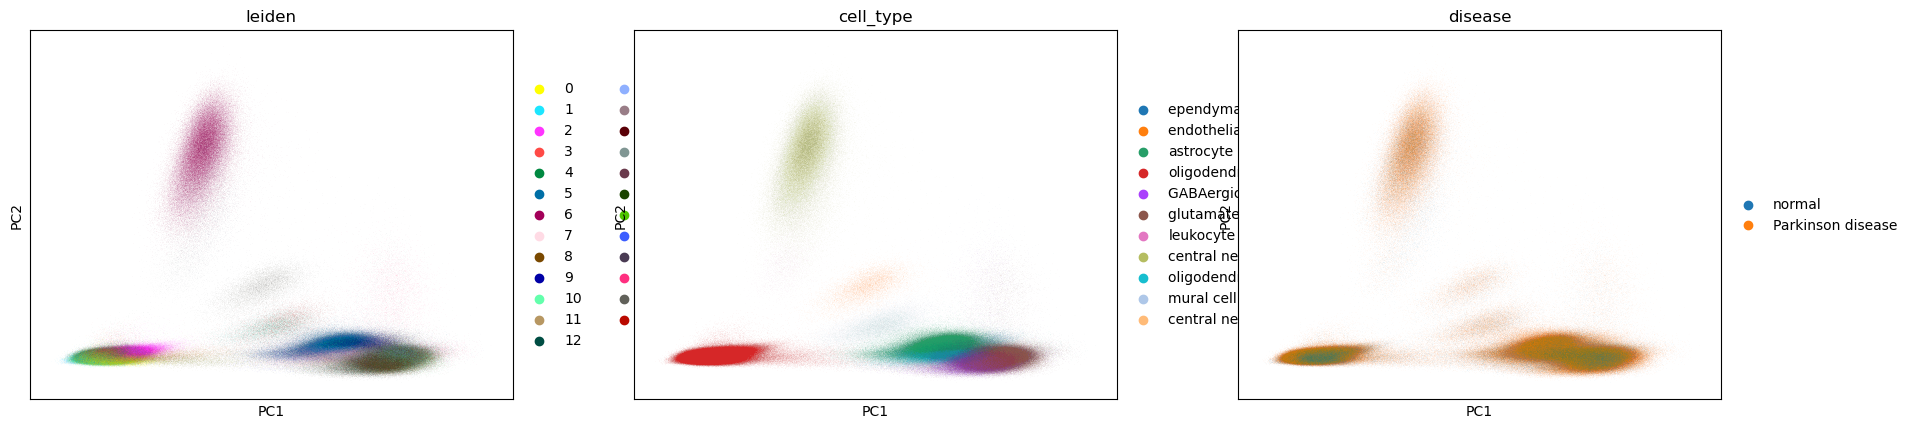

In [8]:
# Plot 

sc.pl.pca_scatter(adata_hvg, color=['leiden', 'cell_type', 'disease'])
